In [1]:
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
the_host = "192.168.1.66"
the_database = "postgres"
the_user = "postgres"
the_password = "postgres"
the_port = 5432

conn = psycopg2.connect(database=the_database, user=the_user, password=the_password, host=the_host, port=the_port)
cur = conn.cursor()

In [5]:
sql = """SELECT ex_balance, btc_exchange_activity.the_date, price_usd 
FROM btc_exchange_activity, btc_price_usd
WHERE btc_exchange_activity.the_date = btc_price_usd.the_date
AND btc_exchange_activity.the_date >= '2021-04-26' ORDER BY the_date;
"""

data = pd.read_sql_query(sql, conn)
corrMatrix = data.corr()
corrMatrix

,ex_balance,price_usd
ex_balance,1.000000,-0.849367
price_usd,-0.849367,1.000000


In [23]:
# Desplazamos los precios un día
# Hay que predecir el precio de hoy, price_usd (o price_diff) en base a las métricas de ayer y antes de ayer
data['price_1'] = data['price_usd'].shift(1)
data['price_diff_now'] = data['price_usd'] - data['price_1']
data['ex_balance_1'] = data['ex_balance'].shift(1)
data['ex_balance_2'] = data['ex_balance'].shift(2)
data['ex_balance_diff'] = data['ex_balance_1'] - data['ex_balance_2']
data['the_date_1'] = data['the_date'].shift(1)

data

,ex_balance,the_date,price_usd,price_1,the_date_1,price_diff_now,ex_balance_1,ex_balance_2,ex_balance_diff,ex_buy,price_diff_10
0,2425121.84,2021-04-26,53943.349978,NaN,NaN,NaN,NaN,NaN,NaN,1,-1
1,2421687.17,2021-04-27,55027.030985,53943.349978,2021-04-26,1083.681006,2425121.84,NaN,NaN,1,1
2,2421134.44,2021-04-28,54787.378707,55027.030985,2021-04-27,-239.652278,2421687.17,2425121.84,-3434.67,1,-1
3,2429626.77,2021-04-29,53567.081194,54787.378707,2021-04-28,-1220.297513,2421134.44,2421687.17,-552.73,1,-1
4,2423798.85,2021-04-30,57741.444417,53567.081194,2021-04-29,4174.363223,2429626.77,2421134.44,8492.33,-1,1
...,...,...,...,...,...,...,...,...,...,...,...
187,2476428.74,2021-10-31,61432.970063,62230.805569,2021-10-29,-797.835506,2479916.95,2475393.97,4522.98,-1,-1
188,2458407.93,2021-11-01,61092.095059,61432.970063,2021-10-31,-340.875004,2476428.74,2479916.95,-3488.21,1,-1
189,2459539.54,2021-11-02,63024.747230,61092.095059,2021-11-01,1932.652170,2458407.93,2476428.74,-18020.81,1,1
190,2452111.98,2021-11-03,62955.981763,63024.747230,2021-11-02,-68.765467,2459539.54,2458407.93,1131.61,-1,-1


In [15]:
data_cor = data[['price_usd', 'price_diff_now', 'price_1', 'ex_balance', 'ex_balance_1', 'ex_balance_2', 'ex_balance_diff']]
data_cor
corrMatrix = data_cor.corr()
corrMatrix

,price_usd,price_diff_now,price_1,ex_balance,ex_balance_1,ex_balance_2,ex_balance_diff
price_usd,1.000000,0.123166,0.982734,-0.849367,-0.847477,-0.843602,-0.000168
price_diff_now,0.123166,1.000000,-0.062577,-0.039702,-0.015791,-0.002912,-0.048098
price_1,0.982734,-0.062577,1.000000,-0.846355,-0.849361,-0.847379,0.008813
ex_balance,-0.849367,-0.039702,-0.846355,1.000000,0.985789,0.964878,0.102440
ex_balance_1,-0.847477,-0.015791,-0.849361,0.985789,1.000000,0.985716,0.063875
ex_balance_2,-0.843602,-0.002912,-0.847379,0.964878,0.985716,1.000000,-0.105111
ex_balance_diff,-0.000168,-0.048098,0.008813,0.102440,0.063875,-0.105111,1.000000


In [21]:
data['ex_buy'] = data.apply(lambda x: -1 if x['ex_balance_diff'] >= 0 else 1, axis=1)
data['price_diff_10'] = data.apply(lambda x: 1 if x['price_diff_now'] >= 0 else -1, axis=1)

In [22]:
ok_ex = 0
ko_ex = 0

for idx, row in data.iterrows():
    if row['ex_buy'] == row['price_diff_10']:
        ok_ex+=1
    else:
        ko_ex+=1

print("OK_ex:" + str(ok_ex))
print("KO_ex:" + str(ko_ex))

OK_ex:103
KO_ex:89


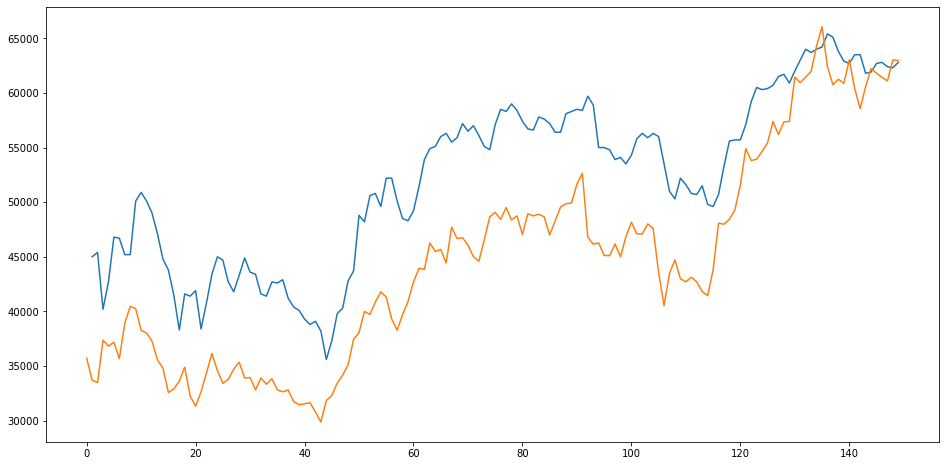

In [82]:
fig = plt.figure(figsize = (16,8))
ax1 = plt.subplot()
plt.plot(data['XXX'])
plt.plot(data['price_usd'])
plt.show()